## Load data

In [2]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the preprocessed dataset
from joblib import load

df = load("/content/drive/MyDrive/liveProject/mortgage_data_preprocess.pkl.gz")

## Separating input and output variables

In [4]:
# removing race, ethnicity, sex and minority population from X
X = df[[
    'loan_amount_000s', 'applicant_income_000s', 'population', 'hud_median_family_income', 'tract_to_msamd_income', 
    'number_of_owner_occupied_units', 'number_of_1_to_4_family_units', 'agency_abbr_CFPB', 'agency_abbr_FDIC',
       'agency_abbr_FRS', 'agency_abbr_HUD', 'agency_abbr_NCUA',
       'agency_abbr_OCC', 'owner_occupancy_name_Not applicable',
       'owner_occupancy_name_Not owner-occupied as a principal dwelling',
       'owner_occupancy_name_Owner-occupied as a principal dwelling',
       'property_type_name_Manufactured housing',
       'property_type_name_One-to-four family dwelling (other than manufactured housing)',
       'loan_purpose_name_Home improvement', 'loan_purpose_name_Home purchase',
       'loan_purpose_name_Refinancing', 'loan_type_name_Conventional',
       'loan_type_name_FHA-insured', 'loan_type_name_FSA/RHS-guaranteed',
       'loan_type_name_VA-guaranteed'
]].copy()

# instantiating the target variable
y = df['action_taken_name']

## Logistic Regression

### Configuration

In [23]:
# instantiate the classifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none")

# instantiate the cross-validation scheme
from sklearn.model_selection import StratifiedKFold
mv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# setup the metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                }

### Modelling loop

In [24]:
import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    # fit model
    lr = lr.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    # get predictions in the test set
    ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = lr.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Explore performance metrics

In [25]:
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])

,mean,std
,Value,Value
Metric,,
AUC,0.575518,0.005068
Accuracy,0.556230,0.003843
F1-Score,0.520497,0.004421
Precision,0.566084,0.004601
Recall,0.481720,0.005075


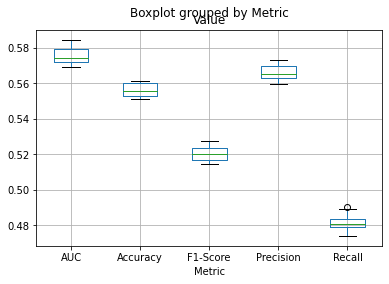

In [26]:
df_metrics.boxplot(column='Value', by='Metric')